In [1]:
import os
import re
import sys
import glob
import time
import uproot
import peakutils

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/') ## Choose right path
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 14

In [4]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [5]:
fav_col = '#418094'

In [36]:
normal_chs = range(9)
trigg_chs  = [9, 10, 11]

## Sum waveforms with only 1 PE per event

In [42]:
filenames    = glob.glob('/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file*.root')
sum_wfs_dict = {}
for ch in normal_chs:
    sum_sel_wfs = np.zeros(7500)
    print(len(filenames))
    for i,filename in enumerate(filenames):
        print(i)
        infile        = uproot.open(filename)
        RawTree       = infile['RawTree']
        wfs           = np.array(RawTree[f'chan{ch}/rdigi'].array())
        swfs          = pf.subtract_baseline(wfs, mode=False, wf_range_bsl=(0, 650))
        max_swfs      = np.max(swfs, axis=1)
        single_pe_rng = (80, 200)
        sel           = (max_swfs>single_pe_rng[0]) & (max_swfs<single_pe_rng[1])
        sum_sel_wfs   = sum_sel_wfs+np.sum(swfs[sel], axis=0)
    sum_wfs_dict[ch] = sum_sel_wfs

34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


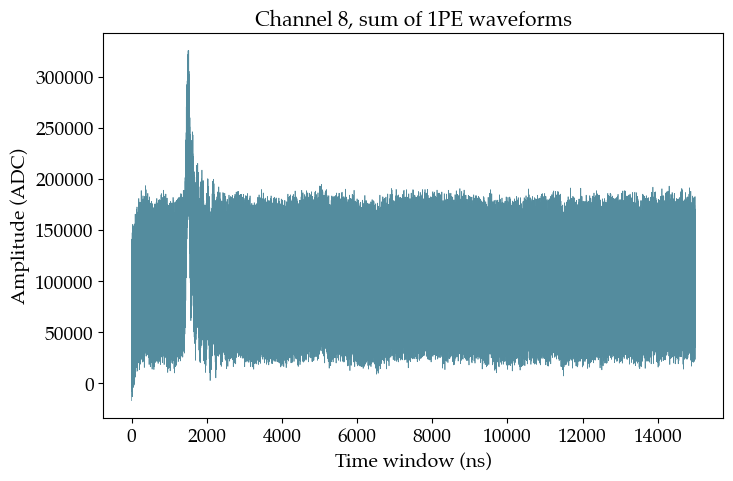

In [43]:
ch = 8
plt.plot(2*np.arange(len(sum_wfs_dict[ch])), sum_wfs_dict[ch], lw=0.5, color=fav_col, alpha=0.9)
plt.title(f'Channel {ch}, sum of 1PE waveforms', fontsize=15)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
#plt.xlim(0, 3000)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/1PE_wfs_and_average_ch8.pdf', bbox_inches='tight')
plt.show()

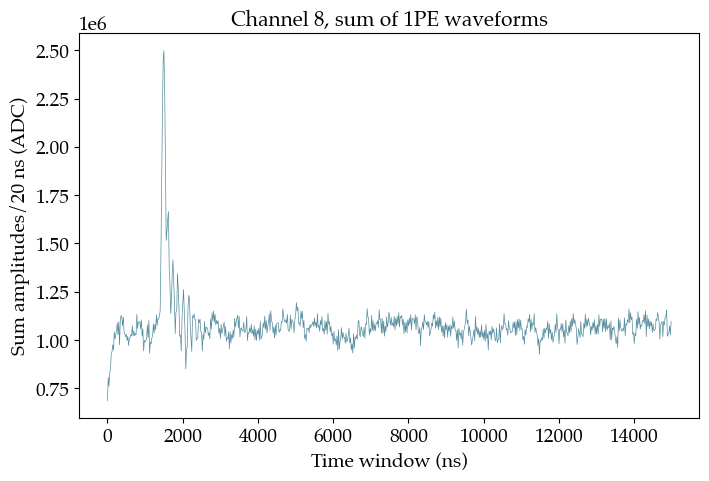

In [44]:
bin_size = 10 #t sample, 20 ns

reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
summed   = reshaped.sum(axis=1)

plt.plot(20*np.arange(len(summed)), summed, lw=0.5, color=fav_col, alpha=0.9)
plt.title(f'Channel {ch}, sum of 1PE waveforms', fontsize=15)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Sum amplitudes/20 ns (ADC)',  fontsize=14)
#plt.xlim(0, 3000)
plt.show()

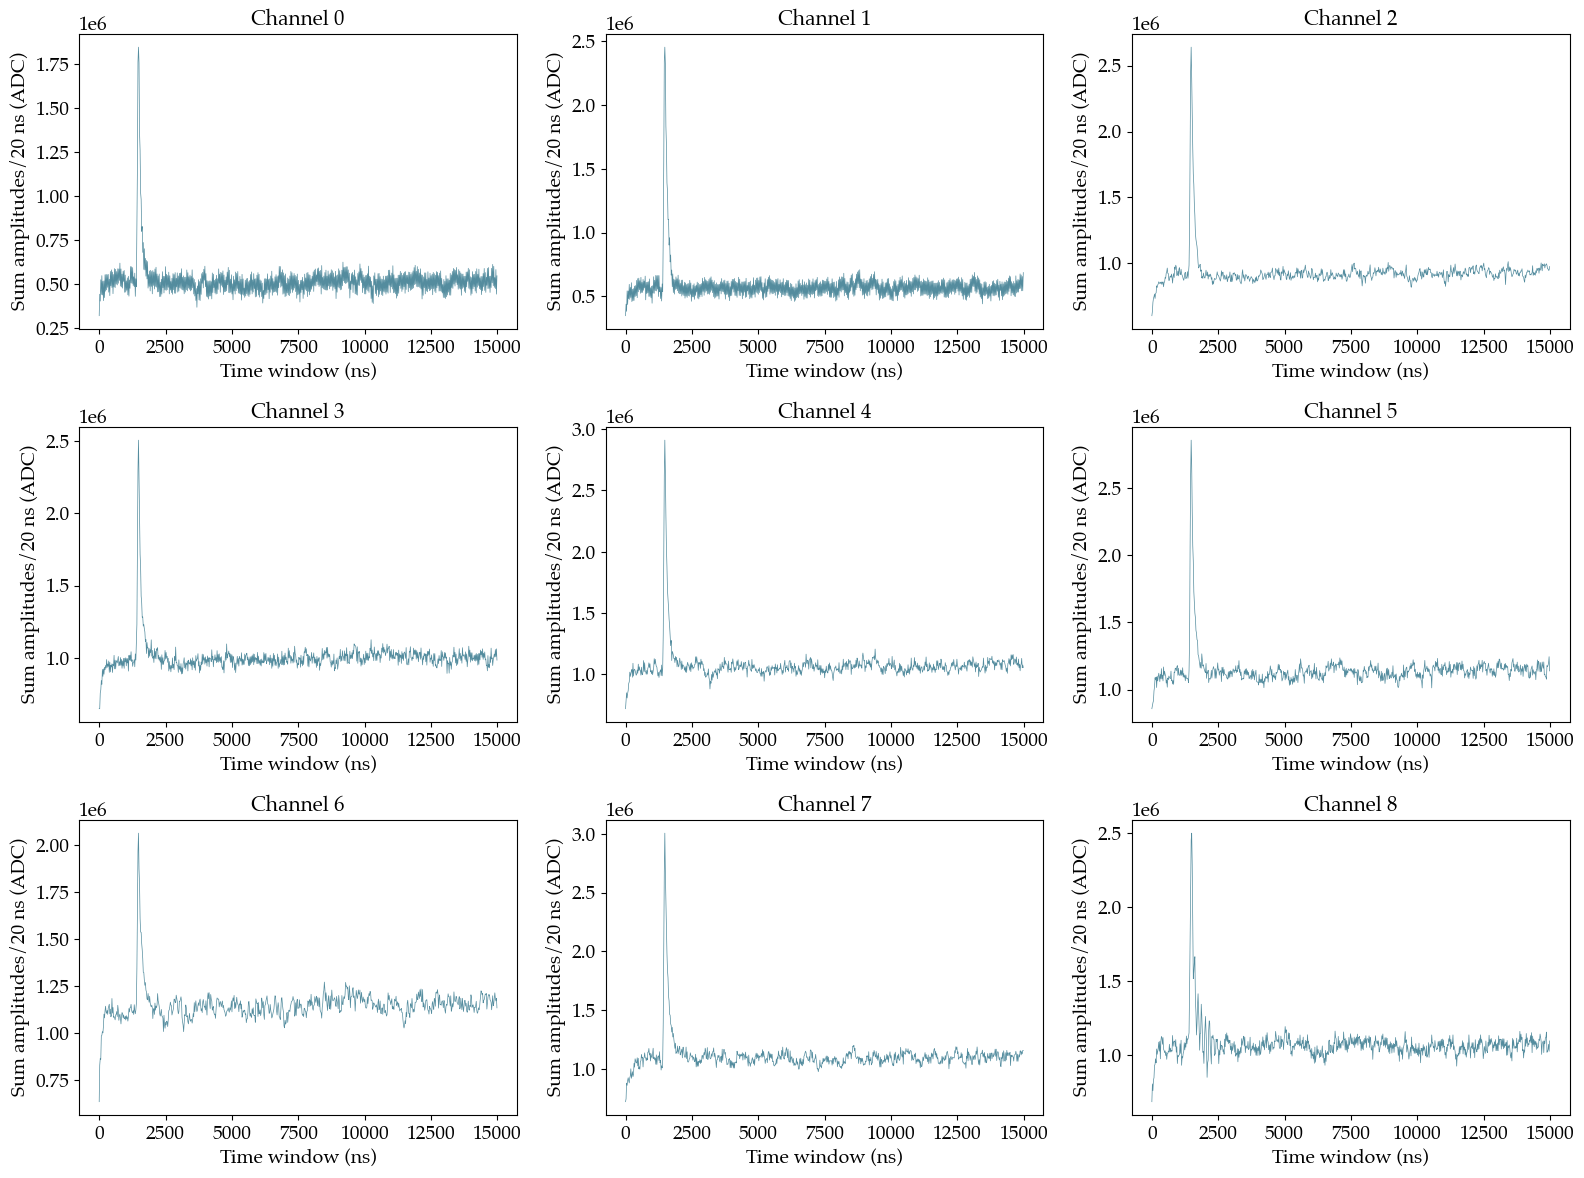

In [47]:
bin_size = 10 #t sample, 20 ns

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
        
    reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
    summed   = reshaped.sum(axis=1)

    axs[i][j].plot(20*np.arange(len(summed)), summed, lw=0.5, color=fav_col, alpha=0.9)
    axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
    axs[i][j].set_ylabel('Sum amplitudes/20 ns (ADC)', fontsize=14)
    axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
plt.tight_layout()
plt.show()

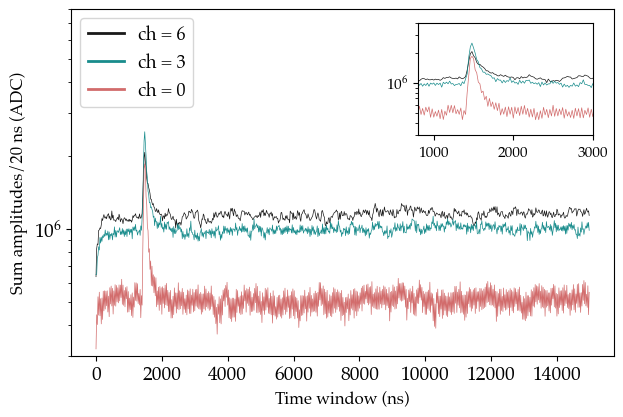

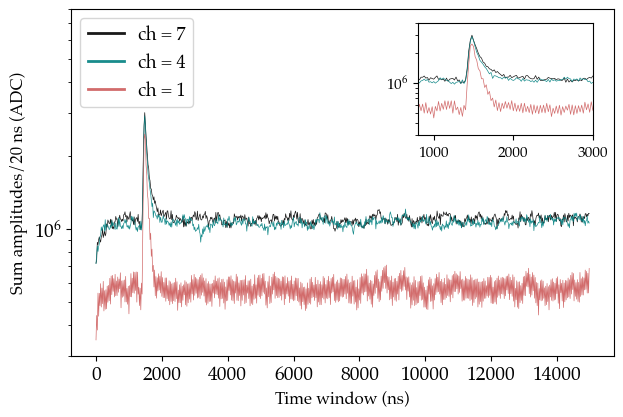

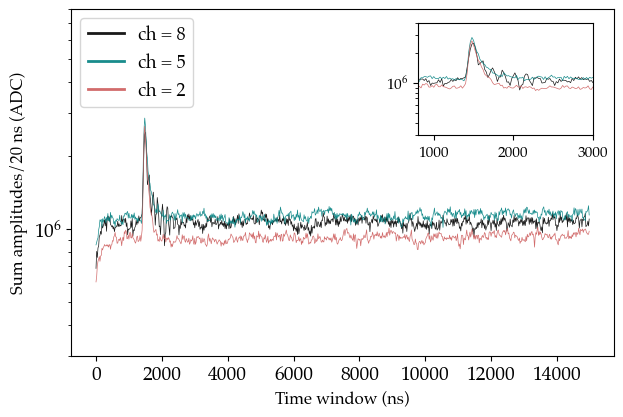

In [60]:
for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)

        plt.plot(20*np.arange(len(summed)), summed, lw=0.5, c=col, alpha=0.9, label=f'ch = {ch}')

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Sum amplitudes/20 ns (ADC)',   fontsize=12)
    plt.yscale('log')
    #plt.xlim(1000, 2500)
    plt.ylim(3e5, 8e6)
    leg = plt.legend(loc='upper left', fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
        
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch,col in zip(sel_chs, ['k', 'teal', 'indianred']):
        reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)

        ax_inset.plot(20*np.arange(len(summed)), summed, lw=0.5, c=col, alpha=0.9, label=f'ch = {ch}')
        
        
    ax_inset.set_xlim(800, 3000)
    ax_inset.set_ylim(3e5, 4e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    #plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/t_dist_1PE_summed_wfs_chs_{sel_chs[0]}_{sel_chs[1]}_{sel_chs[2]}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

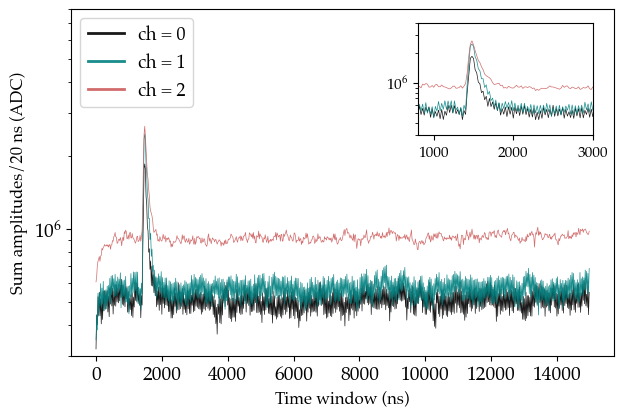

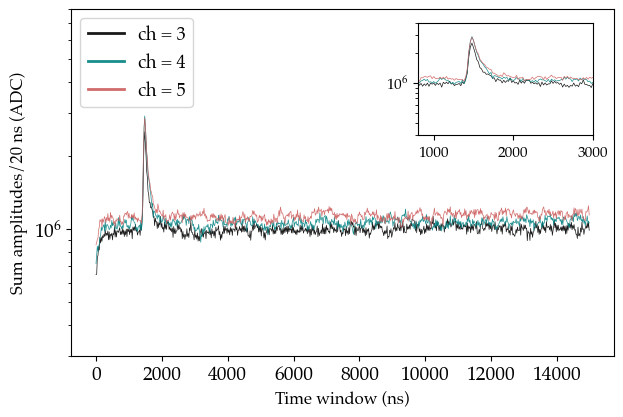

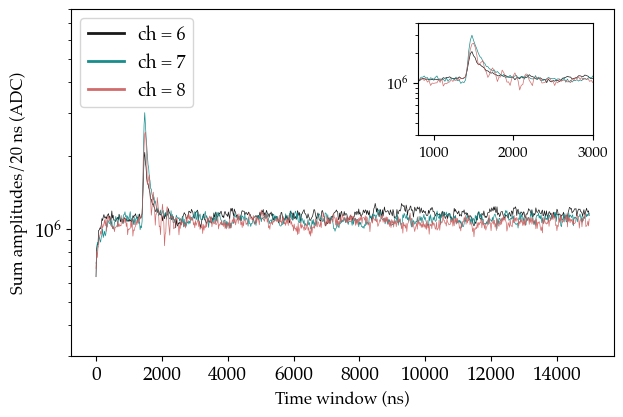

In [62]:
for sel_chs in [[0, 1, 2], [3, 4, 5], [6, 7, 8]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)

        plt.plot(20*np.arange(len(summed)), summed, lw=0.5, c=col, alpha=0.9, label=f'ch = {ch}')

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Sum amplitudes/20 ns (ADC)',   fontsize=12)
    plt.yscale('log')
    #plt.xlim(1000, 2500)
    plt.ylim(3e5, 8e6)
    leg = plt.legend(loc='upper left', fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
        
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch,col in zip(sel_chs, ['k', 'teal', 'indianred']):
        reshaped = sum_wfs_dict[ch][:len(sum_wfs_dict[ch]) - len(sum_wfs_dict[ch]) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)

        ax_inset.plot(20*np.arange(len(summed)), summed, lw=0.5, c=col, alpha=0.9, label=f'ch = {ch}')
        
        
    ax_inset.set_xlim(800, 3000)
    ax_inset.set_ylim(3e5, 4e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    #plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/t_dist_1PE_summed_wfs_chs_{sel_chs[0]}_{sel_chs[1]}_{sel_chs[2]}.pdf', dpi=300, bbox_inches='tight')
    plt.show()